In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("data/smhi-lufttemperatur.csv", sep=";")

In [4]:
df

,Datum,Tid (UTC),Lufttemperatur,Kvalitet
0,2010-03-01,00:00:00,2.0,G
1,2010-03-01,01:00:00,2.2,Y
2,2010-03-01,02:00:00,2.2,Y
3,2010-03-01,03:00:00,1.7,G
4,2010-03-01,04:00:00,1.7,Y
...,...,...,...,...
108214,2022-08-01,02:00:00,16.2,G
108215,2022-08-01,03:00:00,16.0,G
108216,2022-08-01,04:00:00,16.1,G
108217,2022-08-01,05:00:00,17.4,G


### Data preprocessing

In [5]:
def transform(df_: pd.DataFrame) -> pd.DataFrame:
    return (df_
        .rename(columns={"Lufttemperatur": "y", "Kvalitet": "quality"})
        .assign(ds=pd.to_datetime(df_["Datum"] + " " + df_["Tid (UTC)"]))
        .query("quality != 'Y'")
        .loc[:, ("ds", "y")] # type: ignore
        .astype({"y": np.int8}))

In [6]:
weather = transform(df)

In [7]:
weather

,ds,y
0,2010-03-01 00:00:00,2
3,2010-03-01 03:00:00,1
6,2010-03-01 06:00:00,1
9,2010-03-01 09:00:00,1
12,2010-03-01 12:00:00,1
...,...,...
108214,2022-08-01 02:00:00,16
108215,2022-08-01 03:00:00,16
108216,2022-08-01 04:00:00,16
108217,2022-08-01 05:00:00,17


In [8]:
weather.min(), weather.max()

(ds    2010-03-01 00:00:00
 y                     -14
 dtype: object, ds    2022-08-01 06:00:00
 y                      30
 dtype: object)

In [9]:
weather.isna().sum()

ds    0
y     0
dtype: int64

### Data exploration

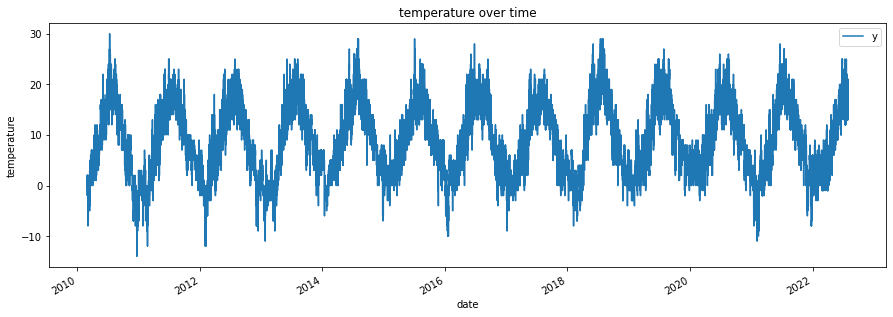

In [10]:
weather.plot(x="ds", y="y", figsize=(15, 5), title="temperature over time", xlabel="date", ylabel="temperature");

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


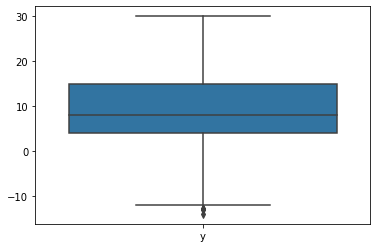

In [11]:
sns.boxplot(data=weather);

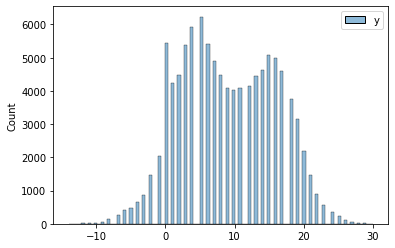

In [13]:
# bimodal
sns.histplot(data=weather); 

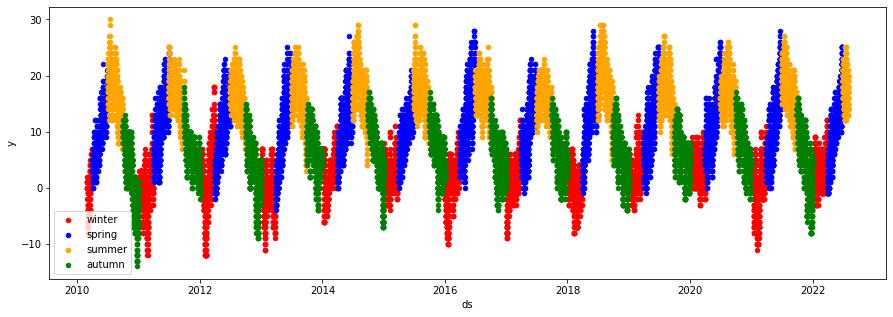

In [43]:
fig, ax = plt.subplots(figsize=(15, 5))
maping = {0: "winter", 1: "spring", 2: "summer", 3: "autumn"}

temp = weather.assign(season=(((weather["ds"]).dt.month - 1) // 3))
temp["season"] = temp.season.map(maping)

temp.query("season == 'winter'").plot(kind="scatter", x="ds", y="y", color="red", label="winter", ax=ax)
temp.query("season == 'spring'").plot(kind="scatter", x="ds", y="y", color="blue", label="spring", ax=ax)
temp.query("season == 'summer'").plot(kind="scatter", x="ds", y="y", color="orange", label="summer", ax=ax)
temp.query("season == 'autumn'").plot(kind="scatter", x="ds", y="y", color="green", label="autumn", ax=ax)
plt.show()

### 1. Spliting

In [77]:
# split data into training and testing (80/20 split).
train = weather[weather["ds"] < pd.Timestamp("2020-02-25")] 
test = weather[weather["ds"] >= pd.Timestamp("2020-02-25")]

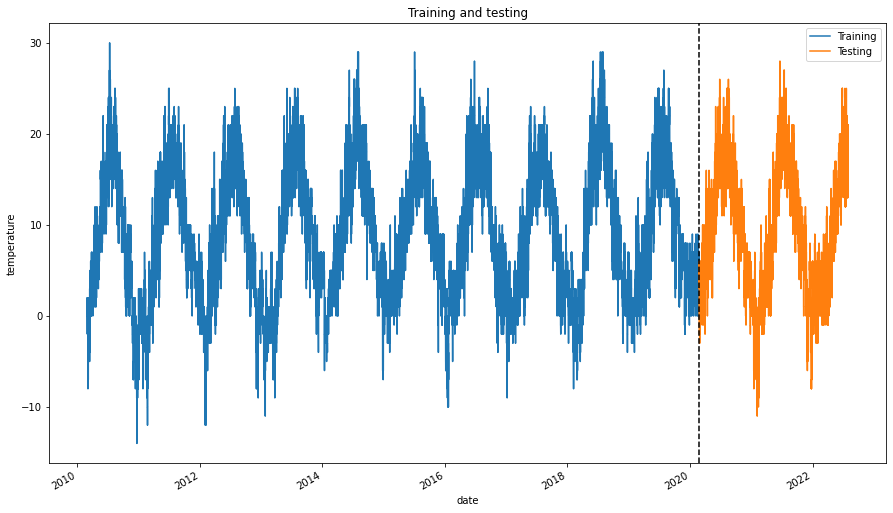

In [78]:
fig, ax = plt.subplots(figsize=(15, 9))
train.plot(ax=ax, x="ds", y="y", label="Training")
test.plot(ax=ax, x="ds", y="y", label="Testing")
ax.axvline(test["ds"].min(), color="black", ls="--")
ax.set(title="Training and testing", xlabel="date", ylabel="temperature")
plt.show()

### 2. Modeling

In [79]:
# fit model - ignore train/test split for now
%%time
m = Prophet()
m.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmprix69dyj/aoppwgwo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprix69dyj/sgt0mww1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89907', 'data', 'file=/tmp/tmprix69dyj/aoppwgwo.json', 'init=/tmp/tmprix69dyj/sgt0mww1.json', 'output', 'file=/tmp/tmprix69dyj/prophet_modely6gj4tpw/prophet_model-20221228173553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 7.69 s, sys: 624 ms, total: 8.31 s
Wall time: 2min 8s


In [93]:
test

,ds,y
87022,2020-02-25 00:00:00,4
87023,2020-02-25 01:00:00,4
87024,2020-02-25 02:00:00,3
87025,2020-02-25 03:00:00,4
87026,2020-02-25 04:00:00,3
...,...,...
108214,2022-08-01 02:00:00,16
108215,2022-08-01 03:00:00,16
108216,2022-08-01 04:00:00,16
108217,2022-08-01 05:00:00,17


In [96]:
#future = m.make_future_dataframe(freq="1h", periods=888*24, include_history=False)
future = pd.DataFrame(test["ds"])

In [97]:
future

,ds
87022,2020-02-25 00:00:00
87023,2020-02-25 01:00:00
87024,2020-02-25 02:00:00
87025,2020-02-25 03:00:00
87026,2020-02-25 04:00:00
...,...
108214,2022-08-01 02:00:00
108215,2022-08-01 03:00:00
108216,2022-08-01 04:00:00
108217,2022-08-01 05:00:00


In [98]:
forecast = m.predict(future)

In [99]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
21192,2022-08-01 02:00:00,21.088114,-3.427502,43.818938
21193,2022-08-01 03:00:00,20.984804,-3.463325,43.435869
21194,2022-08-01 04:00:00,20.981610,-3.438637,43.848285
21195,2022-08-01 05:00:00,21.125689,-3.240443,44.774951
21196,2022-08-01 06:00:00,21.429622,-2.865396,44.332200


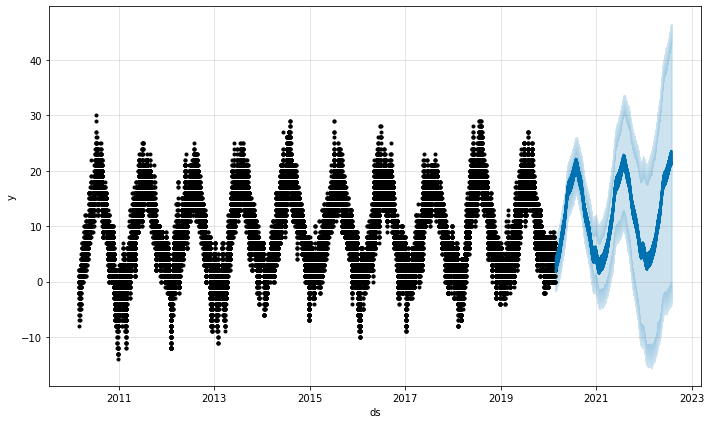

In [100]:
fig1 = m.plot(forecast)

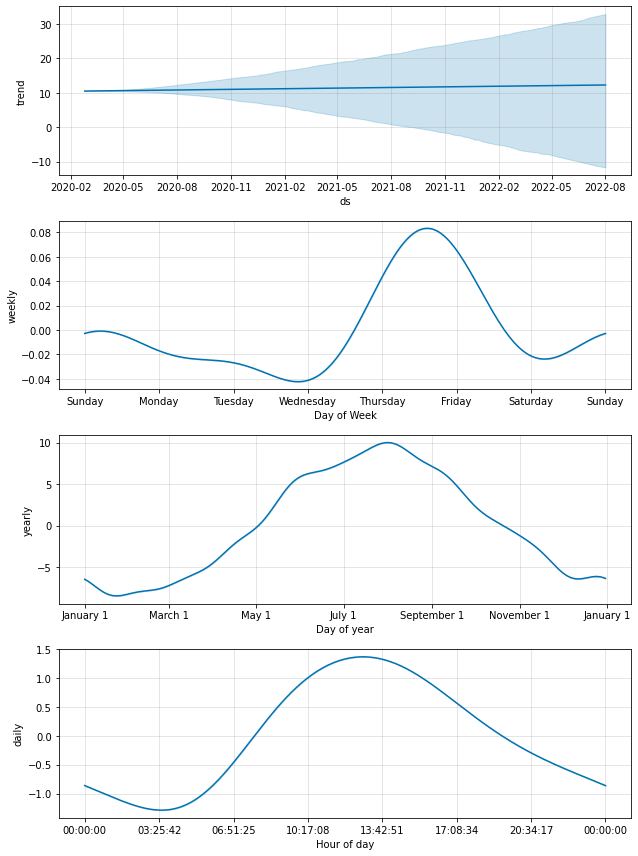

In [94]:
fig2 = m.plot_components(forecast)

### 3. Evaluatiation

In [101]:
pred = pd.DataFrame(dict(ds=test.ds, y=test.y.values, yhat=forecast.yhat.values))

In [102]:
pred

,ds,y,yhat
87022,2020-02-25 00:00:00,4,2.087614
87023,2020-02-25 01:00:00,4,1.931757
87024,2020-02-25 02:00:00,3,1.784910
87025,2020-02-25 03:00:00,4,1.684018
87026,2020-02-25 04:00:00,3,1.683131
...,...,...,...
108214,2022-08-01 02:00:00,16,21.088114
108215,2022-08-01 03:00:00,16,20.984804
108216,2022-08-01 04:00:00,16,20.981610
108217,2022-08-01 05:00:00,17,21.125689


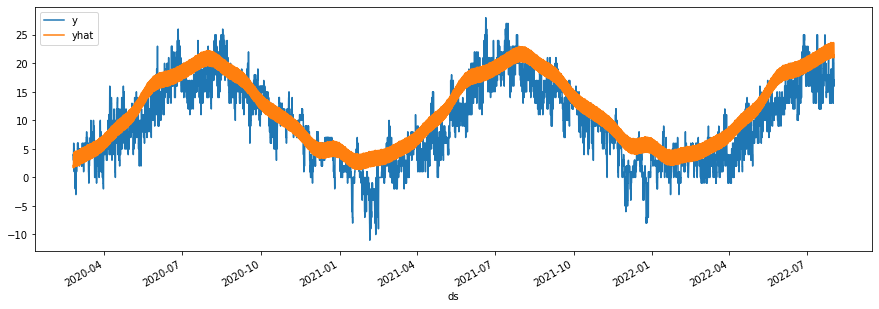

In [104]:
fig, ax = plt.subplots(figsize=(15, 5))
pred.plot(x="ds", y="y", ax=ax)
pred.plot(x="ds", y="yhat", ax=ax)
plt.show()

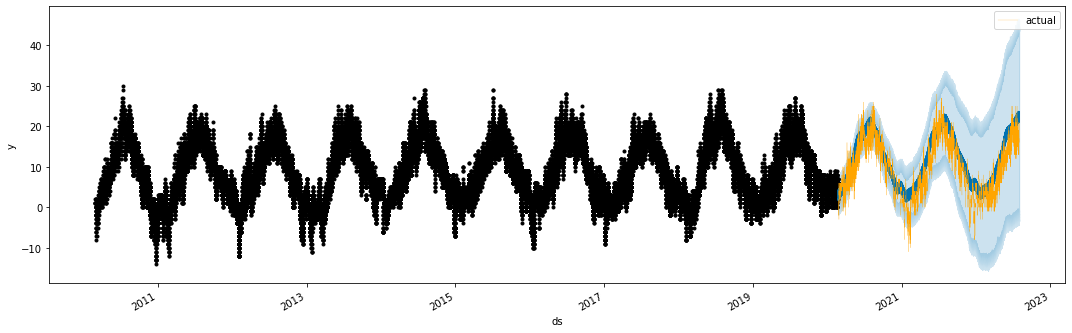

In [109]:
fig, ax = plt.subplots(figsize=(15, 5))

m.plot(forecast, ax=ax)
test.plot(x="ds", y="y", label="actual", color="orange", linewidth=0.2, ax=ax)
plt.show()

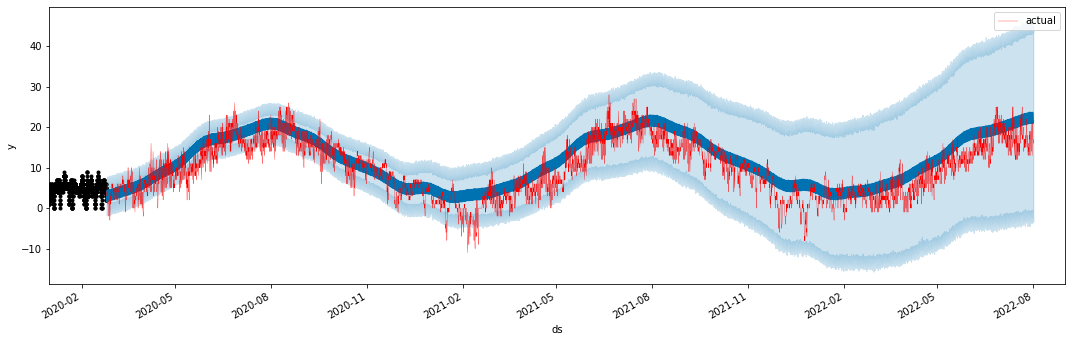

In [113]:
fig, ax = plt.subplots(figsize=(15, 5))

m.plot(forecast, ax=ax)
test.plot(x="ds", y="y", label="actual", color="red", linewidth=0.3, ax=ax)
ax.set_xlim("2020", "2022-09")
plt.show()

In [114]:
mean_squared_error(pred.y, pred.yhat)

12.658488465297626